In [1]:
import pandas as pd
import pickle

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import tree

import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pd.set_option('display.max_columns',None)

In [3]:
players = pd.read_csv("../processed_data/clean/players.csv",index_col = 0)
players.head()

,height,weight,birthDate,collegeName,position,displayName
nflId,,,,,,
2539334,1.83,86,1990-09-10,Washington,CB,Desmond Trufant
2539653,1.78,84,1988-11-01,Southeastern Louisiana,CB,Robert Alford
2543850,1.75,84,1991-12-18,Purdue,SS,Ricardo Allen
2555162,1.85,103,1994-11-04,Louisiana State,MLB,Deion Jones
2555255,1.91,105,1993-07-01,Minnesota,OLB,De'Vondre Campbell


In [4]:
summary = pd.read_csv("summary_teams.csv",index_col=2)
summary

,Unnamed: 0,playId,areaDifference,numberPlayersDeep,numberPlayersDeepDifference,numberPlayersUnderneath,densityDifference,heightDifference,widthDifference,cluster,homeScore,visitorScore,down,quarter,yardsToGo,yardsToEndZone,gameClock,defenseValoration
defenseTeam,,,,,,,,,,,,,,,,,,
PHI,0,2018090600:190:1,55.82550,1,1,5,0.107478,2.76,-10.15,0.0,0.0,0.0,3,1,10,39.0,13:01:00,0
ATL,2,2018090600:344:1,7.82150,1,1,6,0.894969,-0.36,-12.15,0.0,0.0,0.0,3,1,4,102.0,09:24:00,1
PHI,4,2018090600:949:1,64.43250,1,1,6,0.108641,1.64,-6.25,0.0,0.0,3.0,3,2,12,92.0,15:00:00,1
ATL,5,2018090600:1037:1,164.09500,2,1,4,0.036564,5.41,-9.52,1.0,0.0,3.0,3,2,7,57.0,12:53:00,0
ATL,8,2018090600:1801:1,126.91500,1,0,6,0.055155,2.64,-12.52,0.0,3.0,6.0,3,2,3,64.0,01:35:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEA,4550,2018123015:2373:17,-51.20585,1,1,5,-0.117174,2.10,-11.24,0.0,14.0,13.0,3,3,2,83.0,11:58:00,1
SEA,4551,2018123015:2629:17,244.93410,2,2,5,0.028579,8.79,-2.86,0.0,14.0,13.0,3,3,13,58.0,07:43:00,1
SEA,4552,2018123015:2998:17,-72.03590,1,1,5,-0.083292,5.48,-8.06,0.0,21.0,13.0,3,3,10,80.0,04:17:00,1


In [5]:
summary.drop(["Unnamed: 0"],axis=1,inplace=True)

In [6]:
len(summary[summary["defenseValoration"]==0])/len(summary)

0.39392352016762705

In [7]:
len(summary[summary["defenseValoration"]==1])/len(summary)

0.606076479832373

# Cambiar valor gameClock

In [8]:
from datetime import datetime
s1 = "15:00:00"
s2 = "03:29:00"
clock_format = "%M:%S:%f"
time = datetime.strptime(s1, clock_format) - datetime.strptime(s2, clock_format)
print(time.total_seconds())
print(str(time).split(":"))

691.0
['0', '11', '31']


In [9]:
def changeGameClock(value,quarter):
    if quarter == 1:
        total_time = 3600
    elif quarter == 2:
        total_time = 2700
    elif quarter == 3:
        total_time = 1800
    elif quarter == 4:
        total_time = 900
    elif quarter == 5:
        total_time = 900
    
    format = "%M:%S:%f"
    actual_time = datetime.strptime(value, format) - datetime.strptime("00:00:00",format)
    time = total_time - (900 - actual_time.total_seconds())
    return time

In [10]:
changeGameClock("00:07:00",2)

1807.0

In [11]:
summary_cp = summary.copy()

In [12]:
summary_cp["gameClock"] = summary_cp.apply(lambda x: changeGameClock(x["gameClock"],x["quarter"]),axis=1)

In [13]:
summary_cp.drop(["playId"],axis=1,inplace=True)

In [14]:
summary_cp

,areaDifference,numberPlayersDeep,numberPlayersDeepDifference,numberPlayersUnderneath,densityDifference,heightDifference,widthDifference,cluster,homeScore,visitorScore,down,quarter,yardsToGo,yardsToEndZone,gameClock,defenseValoration
defenseTeam,,,,,,,,,,,,,,,,
PHI,55.82550,1,1,5,0.107478,2.76,-10.15,0.0,0.0,0.0,3,1,10,39.0,3481.0,0
ATL,7.82150,1,1,6,0.894969,-0.36,-12.15,0.0,0.0,0.0,3,1,4,102.0,3264.0,1
PHI,64.43250,1,1,6,0.108641,1.64,-6.25,0.0,0.0,3.0,3,2,12,92.0,2700.0,1
ATL,164.09500,2,1,4,0.036564,5.41,-9.52,1.0,0.0,3.0,3,2,7,57.0,2573.0,0
ATL,126.91500,1,0,6,0.055155,2.64,-12.52,0.0,3.0,6.0,3,2,3,64.0,1895.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEA,-51.20585,1,1,5,-0.117174,2.10,-11.24,0.0,14.0,13.0,3,3,2,83.0,1618.0,1
SEA,244.93410,2,2,5,0.028579,8.79,-2.86,0.0,14.0,13.0,3,3,13,58.0,1363.0,1
SEA,-72.03590,1,1,5,-0.083292,5.48,-8.06,0.0,21.0,13.0,3,3,10,80.0,1157.0,1


In [15]:
X_train, X_test, y_train, y_test = train_test_split(summary_cp.drop(["defenseValoration"],axis=1),summary_cp["defenseValoration"],test_size=0.3)

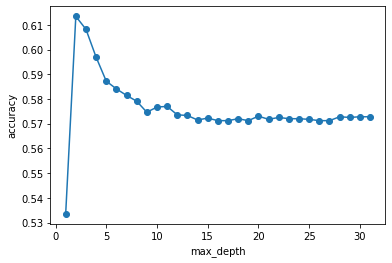

In [16]:
from sklearn import tree
from sklearn.model_selection import KFold

cv = KFold(n_splits = 10, shuffle = False) # 
accuracies = list()
max_attributes = len(list(summary_cp))
depth_range = range(1, max_attributes * 2)

# from 1 to number of features * 2

for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy', 
                                             min_samples_split = 65, 
                                             min_samples_leaf = 20,
                                             max_depth = depth,
                                             class_weight={0:6,1:4}
                                            )
    for train_fold, test_fold in cv.split(summary_cp):
        f_train = summary_cp.iloc[train_fold]
        f_test = summary_cp.iloc[test_fold]
        
        model = tree_model.fit( X = f_train.drop(['defenseValoration'], axis=1), 
                               y = f_train['defenseValoration'])
        test_acc = model.score(X = f_test.drop(['defenseValoration'], axis=1), 
                                y = f_test['defenseValoration'])
        fold_accuracy.append(test_acc)
        
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
import matplotlib.pyplot as plt    
plt.plot(depth_range, accuracies, marker='o')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()

In [51]:
X_train, X_test, y_train, y_test = train_test_split(summary_cp.drop(["defenseValoration"],axis=1),summary_cp["defenseValoration"],test_size=0.3)

In [64]:
from sklearn.model_selection import RandomizedSearchCV
tree_param = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,16,17,18,19,20,21,22,23,24,25],'min_samples_split':[2,4,6,8,10,12,14,16,18,20,22,24,26,28,30],
             'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30],'splitter':["best","random"],
              'class_weight':[{0:6,1:4},{0:1,1:1},{0:2,1:1},{0:3,1:1},{0:4,1:2}]}
tree_model = tree.DecisionTreeClassifier()
clf = RandomizedSearchCV(tree_model, tree_param)

In [65]:
clf.fit(X_train,y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(),
                   param_distributions={'class_weight': [{0: 6, 1: 4},
                                                         {0: 1, 1: 1},
                                                         {0: 2, 1: 1},
                                                         {0: 3, 1: 1},
                                                         {0: 4, 1: 2}],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [4, 5, 6, 7, 8, 9, 10, 11,
                                                      12, 15, 16, 17, 18, 19,
                                                      20, 21, 22, 23, 24, 25],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                        

In [66]:
clf.best_params_

{'splitter': 'best',
 'min_samples_split': 22,
 'min_samples_leaf': 28,
 'max_depth': 12,
 'criterion': 'entropy',
 'class_weight': {0: 6, 1: 4}}

In [67]:
from sklearn.metrics import accuracy_score
regressor = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 12,min_samples_leaf=28,min_samples_split=22,splitter="best",class_weight={0:6,1:4})
regressor.fit( X = X_train, y = y_train)
y_pred = regressor.predict(X = X_test)
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 0.6090750436300174


# Normal model

In [59]:
from sklearn.metrics import accuracy_score
regressor = tree.DecisionTreeClassifier(criterion='entropy', max_depth = 11,min_samples_leaf=1,min_samples_split=2,splitter="random",class_weight={0:6,1:4})
regressor.fit( X = X_train, y = y_train)
y_pred = regressor.predict(X = X_test)
acc = accuracy_score(y_test, y_pred)
print ('Acc', acc)

Acc 0.6134380453752182


In [60]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,normalize=False,title=None,cmap=plt.cm.Blues):
  
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0.58297872 0.41702128]
 [0.37278107 0.62721893]]


<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

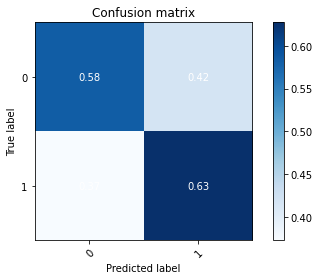

In [68]:
plot_confusion_matrix(y_test, y_pred, classes=unique_labels(y_test,y_pred), normalize=True,
                      title='Confusion matrix')

In [24]:
#save model
pickle_file = open('model_pairs.pickle','wb')
pickle.dump(regressor,pickle_file)
pickle_file.close()

In [54]:
summary

,playId,areaDifference,numberPlayersDeep,numberPlayersDeepDifference,numberPlayersUnderneath,densityDifference,heightDifference,widthDifference,cluster,homeScore,visitorScore,down,quarter,yardsToGo,yardsToEndZone,gameClock,defenseValoration
defenseTeam,,,,,,,,,,,,,,,,,
PHI,2018090600:190:1,55.82550,1,1,5,0.107478,2.76,-10.15,0.0,0.0,0.0,3,1,10,39.0,13:01:00,0
ATL,2018090600:344:1,7.82150,1,1,6,0.894969,-0.36,-12.15,0.0,0.0,0.0,3,1,4,102.0,09:24:00,1
PHI,2018090600:949:1,64.43250,1,1,6,0.108641,1.64,-6.25,0.0,0.0,3.0,3,2,12,92.0,15:00:00,1
ATL,2018090600:1037:1,164.09500,2,1,4,0.036564,5.41,-9.52,1.0,0.0,3.0,3,2,7,57.0,12:53:00,0
ATL,2018090600:1801:1,126.91500,1,0,6,0.055155,2.64,-12.52,0.0,3.0,6.0,3,2,3,64.0,01:35:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEA,2018123015:2373:17,-51.20585,1,1,5,-0.117174,2.10,-11.24,0.0,14.0,13.0,3,3,2,83.0,11:58:00,1
SEA,2018123015:2629:17,244.93410,2,2,5,0.028579,8.79,-2.86,0.0,14.0,13.0,3,3,13,58.0,07:43:00,1
SEA,2018123015:2998:17,-72.03590,1,1,5,-0.083292,5.48,-8.06,0.0,21.0,13.0,3,3,10,80.0,04:17:00,1


In [50]:
summary_players = pd.read_csv("summary_players.csv",index_col=0)
summary_players

,playerId,areaDifference,numberPlayersDeep,numberPlayersDeepDifference,numberPlayersUnderneath,densityDifference,heightDifference,widthDifference,cluster,homeScore,visitorScore,down,quarter,yardsToGo,yardsToEndZone,gameClock,defenseValoration
playId,,,,,,,,,,,,,,,,,
2018090600:190:1,79848.0,55.8255,1,1,5,0.107478,2.76,-10.15,0.0,0.0,0.0,3,1,10,39.0,13:01:00,0
2018090600:190:1,2495613.0,55.8255,1,1,5,0.107478,2.76,-10.15,0.0,0.0,0.0,3,1,10,39.0,13:01:00,0
2018090600:190:1,2534832.0,55.8255,1,1,5,0.107478,2.76,-10.15,0.0,0.0,0.0,3,1,10,39.0,13:01:00,0
2018090600:190:1,2552689.0,55.8255,1,1,5,0.107478,2.76,-10.15,0.0,0.0,0.0,3,1,10,39.0,13:01:00,0
2018090600:190:1,2555383.0,55.8255,1,1,5,0.107478,2.76,-10.15,0.0,0.0,0.0,3,1,10,39.0,13:01:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018123015:3969:17,2539243.0,303.8753,4,3,3,0.023036,7.90,-6.77,0.0,24.0,21.0,3,4,12,37.0,02:00:00,1
2018123015:3969:17,2553456.0,303.8753,4,3,3,0.023036,7.90,-6.77,0.0,24.0,21.0,3,4,12,37.0,02:00:00,1
2018123015:3969:17,2553637.0,303.8753,4,3,3,0.023036,7.90,-6.77,0.0,24.0,21.0,3,4,12,37.0,02:00:00,1


In [27]:
from itertools import combinations
def extract_combinations(play):
    players = summary_players.loc[play]["playerId"].values
    set_comb = set()
    for comb in combinations(players, 2):
        set_comb.add(tuple(sorted(comb)))
    return set_comb

In [28]:
pairs = pd.DataFrame()

In [29]:
pairs["playId"] = ""

In [30]:
pairs["pairs"] = ""

In [31]:
for play in summary["playId"]:
    pairs_play = extract_combinations(play)
    
    for pair in pairs_play:
        pairs = pairs.append({"playId":play,"pairs":pair},ignore_index=True)

In [32]:
pairs

,playId,pairs
0,2018090600:190:1,"(79848.0, 2555383.0)"
1,2018090600:190:1,"(79848.0, 2552689.0)"
2,2018090600:190:1,"(2534832.0, 2552689.0)"
3,2018090600:190:1,"(2552689.0, 2555383.0)"
4,2018090600:190:1,"(2495613.0, 2552689.0)"
...,...,...
71814,2018123015:3969:17,"(2558077.0, 2560728.0)"
71815,2018123015:3969:17,"(2532966.0, 2553456.0)"
71816,2018123015:3969:17,"(2539243.0, 2553456.0)"
71817,2018123015:3969:17,"(2534846.0, 2558077.0)"


In [33]:
pairs = pairs.set_index("playId")

In [34]:
predict_proba = regressor.predict_proba(summary_cp.drop(["defenseValoration"],axis=1))[:,1]

In [55]:
summary["predict_proba"] = predict_proba - (1 - predict_proba)
summary

,playId,areaDifference,numberPlayersDeep,numberPlayersDeepDifference,numberPlayersUnderneath,densityDifference,heightDifference,widthDifference,cluster,homeScore,visitorScore,down,quarter,yardsToGo,yardsToEndZone,gameClock,defenseValoration,predict_proba
defenseTeam,,,,,,,,,,,,,,,,,,
PHI,2018090600:190:1,55.82550,1,1,5,0.107478,2.76,-10.15,0.0,0.0,0.0,3,1,10,39.0,13:01:00,0,0.068085
ATL,2018090600:344:1,7.82150,1,1,6,0.894969,-0.36,-12.15,0.0,0.0,0.0,3,1,4,102.0,09:24:00,1,0.020408
PHI,2018090600:949:1,64.43250,1,1,6,0.108641,1.64,-6.25,0.0,0.0,3.0,3,2,12,92.0,15:00:00,1,0.548387
ATL,2018090600:1037:1,164.09500,2,1,4,0.036564,5.41,-9.52,1.0,0.0,3.0,3,2,7,57.0,12:53:00,0,-0.190926
ATL,2018090600:1801:1,126.91500,1,0,6,0.055155,2.64,-12.52,0.0,3.0,6.0,3,2,3,64.0,01:35:00,1,-0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEA,2018123015:2373:17,-51.20585,1,1,5,-0.117174,2.10,-11.24,0.0,14.0,13.0,3,3,2,83.0,11:58:00,1,-0.384615
SEA,2018123015:2629:17,244.93410,2,2,5,0.028579,8.79,-2.86,0.0,14.0,13.0,3,3,13,58.0,07:43:00,1,0.120000
SEA,2018123015:2998:17,-72.03590,1,1,5,-0.083292,5.48,-8.06,0.0,21.0,13.0,3,3,10,80.0,04:17:00,1,0.068085


In [56]:
predict_proba_sums_team = summary.groupby(summary.index)["predict_proba"].sum()
predict_proba_sums_team

defenseTeam
ARI    14.506714
ATL    12.775481
BAL    19.218673
BUF    10.982149
CAR     9.995540
CHI    13.804216
CIN    -3.817164
CLE    19.129212
DAL     7.185953
DEN    12.661947
DET     8.997594
GB      2.354422
HOU     1.359289
IND    13.592886
JAX    15.597382
KC     10.089570
LA     11.741740
LAC    13.146759
MIA    -0.491255
MIN    20.547502
NE      8.596774
NO      6.398311
NYG    -1.450432
NYJ    10.555534
OAK    11.318448
PHI    11.923199
PIT    24.409186
SEA    -2.207741
SF      7.335508
TB     13.988423
TEN    11.262424
WAS    13.235792
Name: predict_proba, dtype: float64

In [57]:
predict_proba_sums_team = predict_proba_sums_team.sort_values(ascending=False)

In [58]:
predict_proba_sums_team.to_csv("teams_evaluations.csv")

In [36]:
summary = summary.set_index("playId")

In [37]:
pairs["predict_proba"] = ""

In [38]:
for play in summary.index:
    pairs.loc[play,"predict_proba"] = summary.loc[play]["predict_proba"]

In [42]:
predict_proba_sums = pairs.groupby("pairs")["predict_proba"].sum()
predict_proba_sums

pairs
(306.0, 2495153.0)        0.423526
(306.0, 2495617.0)        0.404160
(306.0, 2506353.0)        0.708646
(306.0, 2507167.0)        2.267597
(306.0, 2532871.0)       -0.190926
                            ...   
(2561103.0, 2561417.0)   -1.089334
(2561131.0, 2561149.0)   -0.714286
(2561131.0, 2561155.0)   -0.593665
(2561147.0, 2561316.0)    0.945244
(2561383.0, 2561417.0)   -1.000000
Name: predict_proba, Length: 3663, dtype: float64

In [43]:
predict_proba_sums.sort_values(ascending=False)

pairs
(496733.0, 2560712.0)     24.226761
(2556559.0, 2560712.0)    22.324687
(2532946.0, 2560712.0)    22.324535
(2555386.0, 2560712.0)    22.120347
(496733.0, 2532946.0)     22.095716
                            ...    
(2533060.0, 2560970.0)    -5.285578
(2559208.0, 2560713.0)    -5.442403
(2558077.0, 2560728.0)    -5.528646
(2532966.0, 2558077.0)    -5.738540
(2533060.0, 2539233.0)    -7.289750
Name: predict_proba, Length: 3663, dtype: float64

In [44]:
predict_proba_sums = predict_proba_sums.sort_values(ascending=False)

In [45]:
predict_proba_sums.to_csv("pairs_evaluations.csv")

In [57]:
players.loc[496733]

height                1.8
weight                 88
birthDate      1989-04-14
collegeName       Florida
position               CB
displayName     Joe Haden
Name: 496733, dtype: object

In [58]:
players.loc[2560712]

height                    1.85
weight                      98
birthDate           1997-01-20
collegeName      Virginia Tech
position                     S
displayName    Terrell Edmunds
Name: 2560712, dtype: object

In [25]:
summary

,playId,areaDifference,numberPlayersDeep,numberPlayersDeepDifference,numberPlayersUnderneath,densityDifference,heightDifference,widthDifference,cluster,homeScore,visitorScore,down,quarter,yardsToGo,yardsToEndZone,gameClock,defenseValoration,predict_proba
defenseTeam,,,,,,,,,,,,,,,,,,
PHI,2018090600:190:1,55.82550,1,1,5,0.107478,2.76,-10.15,0.0,0.0,0.0,3,1,10,39.0,13:01:00,0,0.200000
ATL,2018090600:344:1,7.82150,1,1,6,0.894969,-0.36,-12.15,0.0,0.0,0.0,3,1,4,102.0,09:24:00,1,-0.119403
PHI,2018090600:949:1,64.43250,1,1,6,0.108641,1.64,-6.25,0.0,0.0,3.0,3,2,12,92.0,15:00:00,1,1.000000
ATL,2018090600:1037:1,164.09500,2,1,4,0.036564,5.41,-9.52,1.0,0.0,3.0,3,2,7,57.0,12:53:00,0,0.038674
ATL,2018090600:1801:1,126.91500,1,0,6,0.055155,2.64,-12.52,0.0,3.0,6.0,3,2,3,64.0,01:35:00,1,-0.224490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEA,2018123015:2373:17,-51.20585,1,1,5,-0.117174,2.10,-11.24,0.0,14.0,13.0,3,3,2,83.0,11:58:00,1,-0.578947
SEA,2018123015:2629:17,244.93410,2,2,5,0.028579,8.79,-2.86,0.0,14.0,13.0,3,3,13,58.0,07:43:00,1,0.739130
SEA,2018123015:2998:17,-72.03590,1,1,5,-0.083292,5.48,-8.06,0.0,21.0,13.0,3,3,10,80.0,04:17:00,1,0.200000
